# Hierarchical Gating

A common strategy for manual gating is *hierarchical gating* -- a skilled cytometrist examines sets of one- or two-dimensional plots, one after another, to separate cells into "positive" and "negative" populations. While I like to think that modern cytometry has better, less biased tools to accomplish this task, it is still a necessary one in many contexts, and `Cytoflow` supports it.

This notebook demonstrates a hierarchical gating scheme from `Saeys Y, Van Gassen S, Lambrecht BN. Computational flow cytometry: helping to make sense of high-dimensional immunology data. Nature Reviews Immunology 16:449-462 (2016)`. Our question here is a basic one -- **what is the count of each cell type in each tube in the six tubes in the experiment?** The data were downloaded from [the Sayes Lab github](https://github.com/saeyslab/FlowSOM_workshop) and compensated using the bleedthrough matrix in the provided FlowJo workspace before being re-saved by `Cytoflow` -- no other data preprocessing was applied.

We want to quantify NK, NK T, T and B cells; neutrophils, DCs, basophils, and macrophages. The markers (and the channels they were measured in) are in the table below (also from the Sayes lab github). Per [https://flowrepository.org/experiments/833], these cells were splenocytes from wild-type C57Bl/6 mice.

![Markers](_images/sayes_markers.png)

## Set up the notebook and import the data set

In [1]:
# set up the notebook
%matplotlib widget

In [2]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

In `Cytoflow`, we'd usually add additional metadata to each tube. Here, however, all we have is the tube number. We are going to use the `channels` attribute of `ImportOp` to map channels to markers, though. (I don't know which marker is on the *AmCyan* or *Pacific Blue* channels, though. And let's be clear, I am *not* an immunologist, to know about any of these markers!)

In [3]:
import_op = flow.ImportOp(conditions = {"Tube" : "category"},
                          tubes = [flow.Tube(file='data/Saeys_11.fcs', conditions = {"Tube" : "11"}), 
                                   flow.Tube(file='data/Saeys_12.fcs', conditions = {"Tube" : "12"}),
                                   flow.Tube(file='data/Saeys_13.fcs', conditions = {"Tube" : "13"}),
                                   flow.Tube(file='data/Saeys_28.fcs', conditions = {"Tube" : "28"}),
                                   flow.Tube(file='data/Saeys_30.fcs', conditions = {"Tube" : "30"}),
                                   flow.Tube(file='data/Saeys_31.fcs', conditions = {"Tube" : "31"})],
                          channels = {"FSC-A" : "FSC_A",
                                      "FSC-H" : "FSC_H",
                                      "APC-Cy7-A" : "Live_Dead",
                                      "AmCyan-A" : "AmCyan",
                                      "BV711-A" : "CD64",
                                      "PE-A" : "CD3",
                                      "PE-Cy5-A" : "CD19",
                                      "APC-A" : "CD161",
                                      "PE-Cy7-A" : "CD11c",
                                      "PerCP-Cy5-5-A" : "MHCII",
                                      "Alexa Fluor 700-A" : "Ly_6G",
                                      "BV605-A" : "CD11b",
                                      "BV786-A" : "FcERI",
                                      "Pacific Blue-A" : "Pacific_Blue"})

ex = import_op.apply()

## Gate single cells and live cells
First, gate on `FSC_A` and `FSC-H` to separate single cells from debris and clumps.

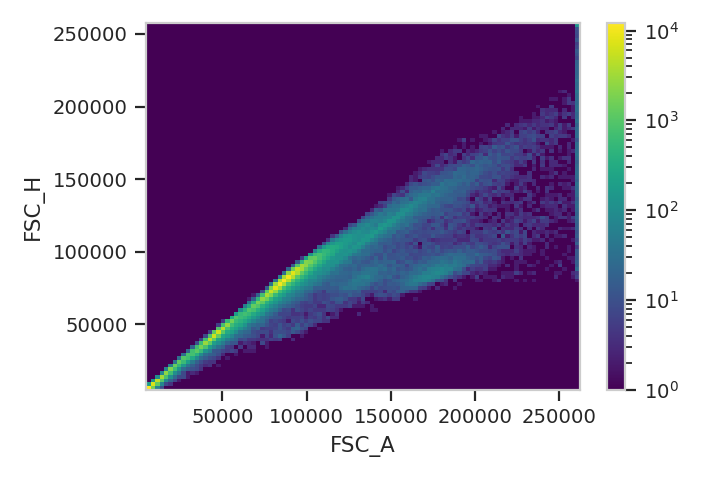

In [4]:
single_gate = flow.PolygonOp(name = "Single_Cell",
                             xchannel = "FSC_A",
                             ychannel = "FSC_H")
single_gate.default_view(density = True,
                         huescale = "log",
                         interactive = True).plot(ex, gridsize = 100)

In [5]:
ex_single = single_gate.apply(ex)

Next, gate on `FSC_A` and `Live_Dead` to find live cells. Remember, dead cells are the *positive* population!

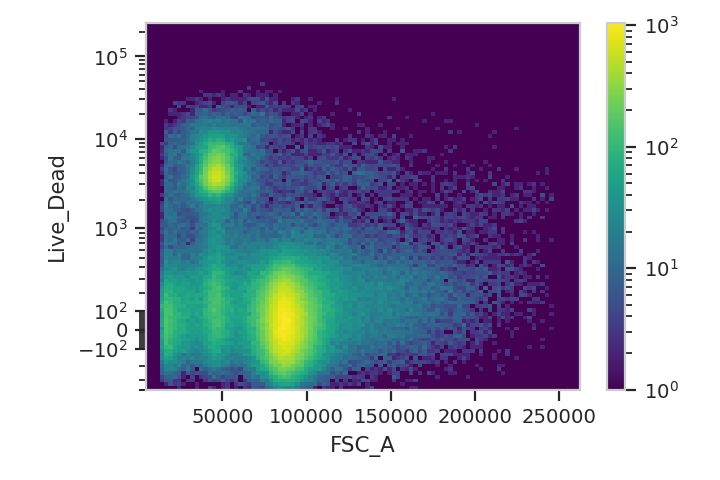

In [6]:
live_gate = flow.PolygonOp(name = "Live",
                           xchannel = "FSC_A",
                           ychannel = "Live_Dead",
                           yscale = "logicle")
live_gate.default_view(density = True,
                       huescale = "log",
                       subset = "Single_Cell == True",
                       interactive = True).plot(ex_single, gridsize = 100)

In [7]:
ex_live = live_gate.apply(ex_single)

## Gate immune cells

Now, we'll set up a single gate for each immunological population we're interested in. Here, we are *not* looking at subsets defined by previous gates -- instead, for each population, we're *just* plotting cells that are `Single_Cell == True` and also `Live == True`.

We start with **macrophages**, which are **CD64 high** and **AmCyan high**

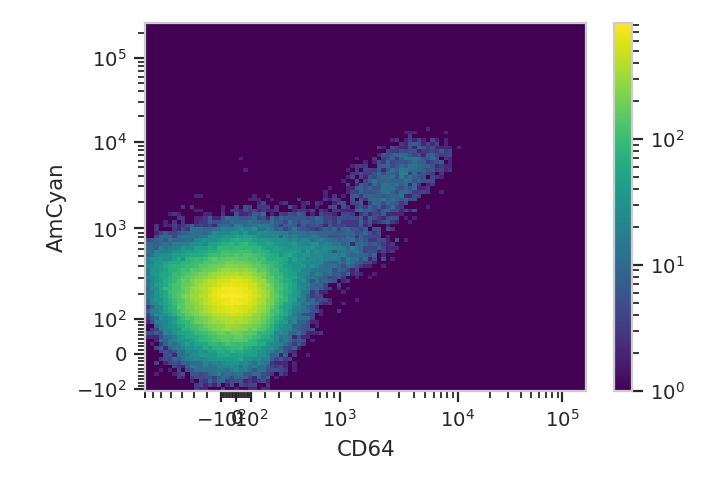

In [8]:
macrophage_gate = flow.PolygonOp(name = "Macrophage",
                                 xchannel = "CD64",
                                 xscale = "logicle",
                                 ychannel = "AmCyan",
                                 yscale = "logicle")
macrophage_gate.default_view(density = True,
                             huescale = "log",
                             subset = "Single_Cell == True & Live == True",
                             interactive = True).plot(ex_live, gridsize = 100)

**B cells** are **CD19 high** and **CD3 low**.

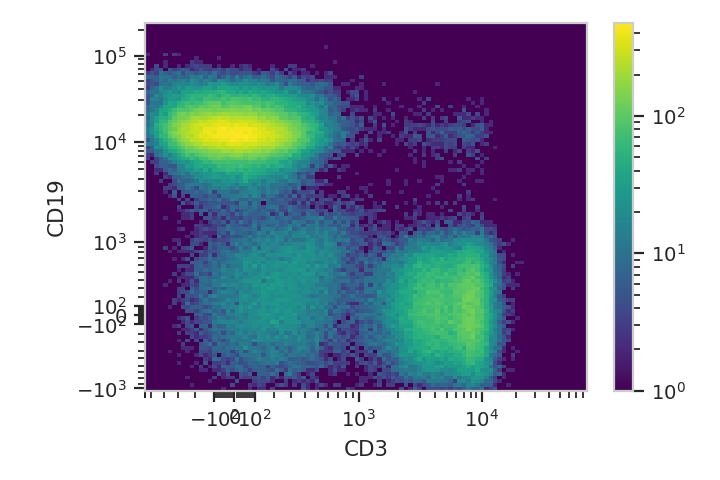

In [9]:
bcell_gate = flow.PolygonOp(name = "B_Cell",
                            xchannel = "CD3",
                            xscale = "logicle",
                            ychannel = "CD19",
                            yscale = "logicle")
bcell_gate.default_view(density = True,
                        huescale = "log",
                        subset = "Single_Cell == True & Live == True",
                        interactive = True).plot(ex_live, gridsize = 100)

We can use **CD3** and **CD161** to distinguish **NK**, **NK T** and **T Cells**.

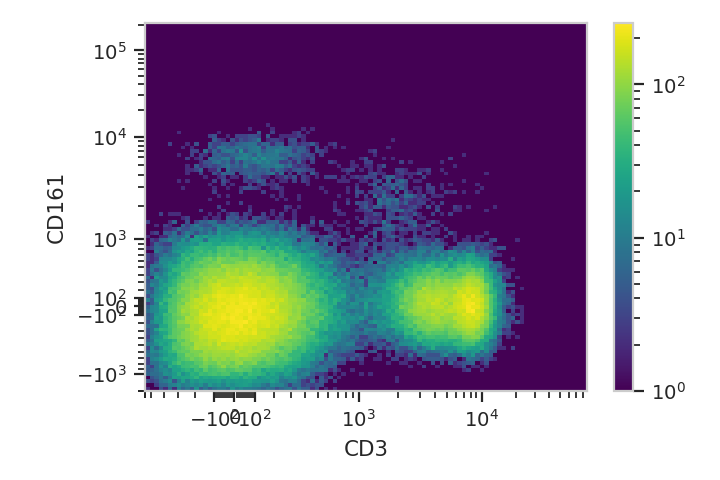

In [10]:
nk_gate = flow.PolygonOp(name = "NK",
                         xchannel = "CD3",
                         xscale = "logicle",
                         ychannel = "CD161",
                         yscale = "logicle")
nk_gate.default_view(density = True,
                     huescale = "log",
                     subset = "Single_Cell == True & Live == True",
                     interactive = True).plot(ex_live, gridsize = 100)

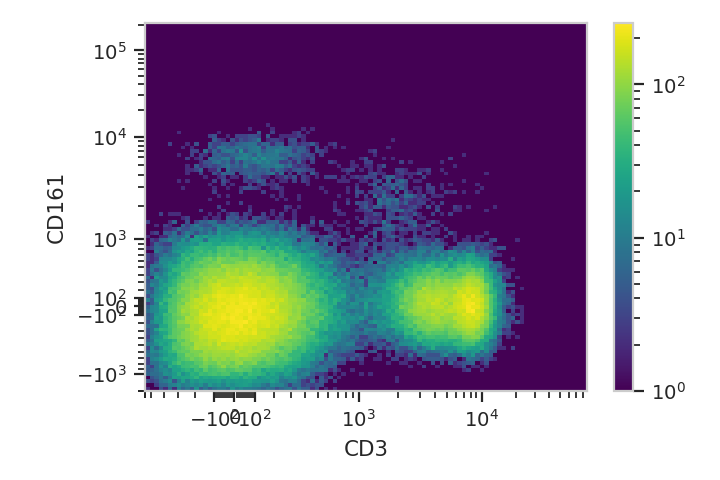

In [12]:
nkt_gate = flow.PolygonOp(name = "NK_T",
                          xchannel = "CD3",
                          xscale = "logicle",
                          ychannel = "CD161",
                          yscale = "logicle")
nkt_gate.default_view(density = True,
                      huescale = "log",
                      subset = "Single_Cell == True & Live == True",
                      interactive = True).plot(ex_live, gridsize = 100)

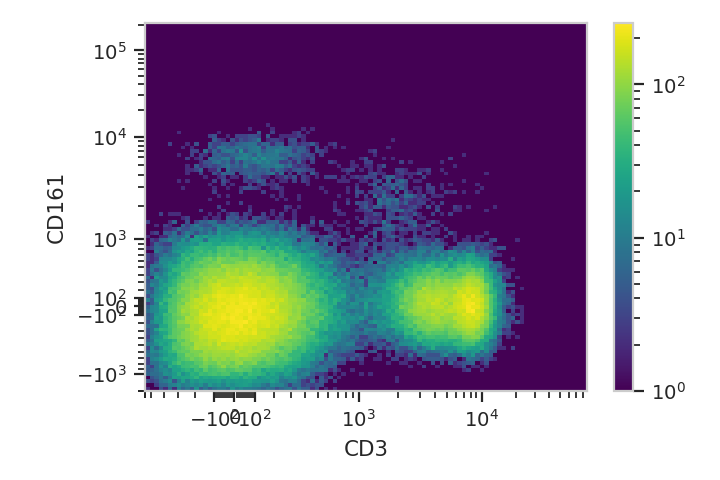

In [13]:
tcell_gate = flow.PolygonOp(name = "T_Cell",
                            xchannel = "CD3",
                            xscale = "logicle",
                            ychannel = "CD161",
                            yscale = "logicle")
tcell_gate.default_view(density = True,
                        huescale = "log",
                        subset = "Single_Cell == True & Live == True",
                        interactive = True).plot(ex_live, gridsize = 100)

**DCs** are **CD11c high** and **MHCII high**

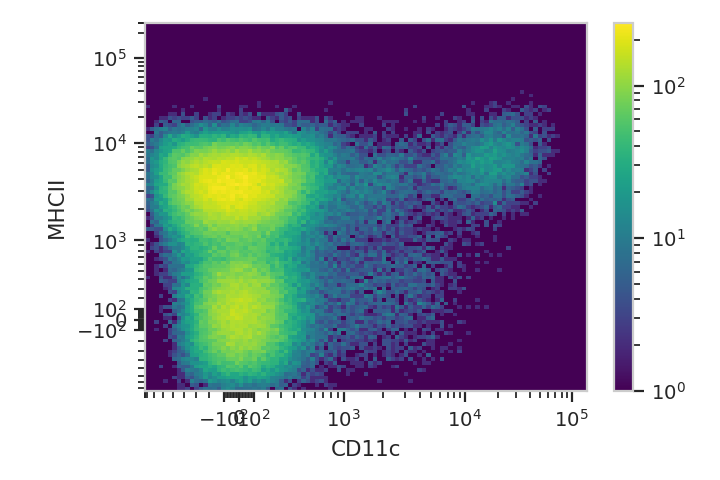

In [14]:
dc_gate = flow.PolygonOp(name = "DC",
                         xchannel = "CD11c",
                         xscale = "logicle",
                         ychannel = "MHCII",
                         yscale = "logicle")
dc_gate.default_view(density = True,
                     huescale = "log",
                     subset = "Single_Cell == True & Live == True",
                     interactive = True).plot(ex_live, gridsize = 100)

Neutrophils are **Ly-6G high** and **CD11b high**.

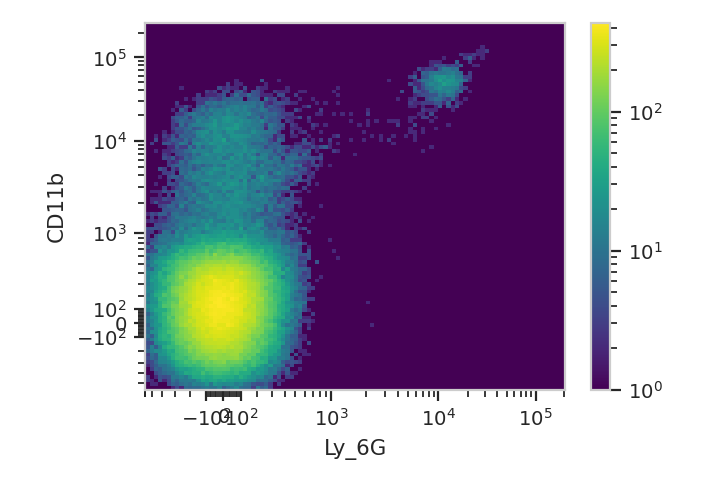

In [15]:
neutrophil_gate = flow.PolygonOp(name = "Neutrophil",
                                 xchannel = "Ly_6G",
                                 xscale = "logicle",
                                 ychannel = "CD11b",
                                 yscale = "logicle")
neutrophil_gate.default_view(density = True,
                             huescale = "log",
                             subset = "Single_Cell == True & Live == True",
                             interactive = True).plot(ex_live, gridsize = 100)

Finally, **basophils** are **FcERI high**. (I don't know what marker is on the **Pacific Blue** channel -- they seem to be high for that marker too.

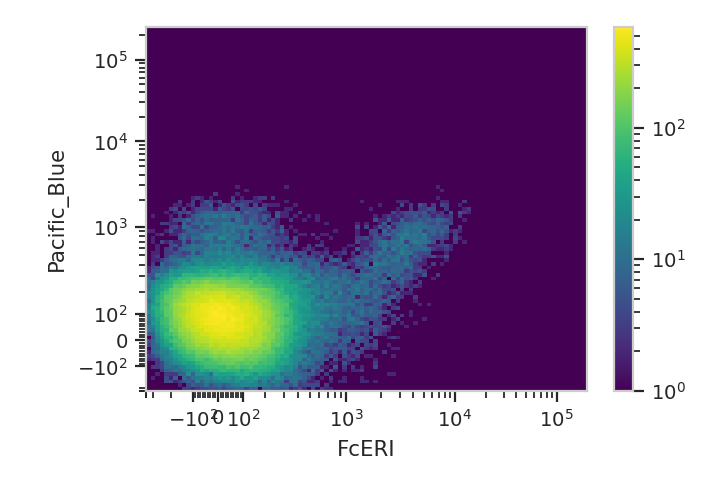

In [16]:
basophil_gate = flow.PolygonOp(name = "Basophil",
                               xchannel = "FcERI",
                               xscale = "logicle",
                               ychannel = "Pacific_Blue",
                               yscale = "logicle")
basophil_gate.default_view(density = True,
                           huescale = "log",
                           subset = "Single_Cell == True & Live == True",
                           interactive = True).plot(ex_live, gridsize = 100)

## Apply the gates and analyze the result

Up to now, we've created and parameterized the various gates. Let's apply all of them sequentially.

In [17]:
ex_gated = macrophage_gate.apply(ex_live)
ex_gated = bcell_gate.apply(ex_gated)
ex_gated = nk_gate.apply(ex_gated)
ex_gated = nkt_gate.apply(ex_gated)
ex_gated = tcell_gate.apply(ex_gated)
ex_gated = dc_gate.apply(ex_gated)
ex_gated = neutrophil_gate.apply(ex_gated)
ex_gated = basophil_gate.apply(ex_gated)

Now we can apply the hierarchical gating strategy. The `HierarchyOp` operation uses an ordered series of gates to create a new categorical condition. You parameterize it with a list of gates, values, and labels. If an event has the first condition equal to the first value, it gets the first label. Otherwise, if it has the second condition equal to the second value, it gets the second label. And so on. Left over events get a default label, which is `Unknown` by default.

In [18]:
ex_hierarchy = flow.HierarchyOp(name = "Cell_Type",
                                gates = [("Macrophage", True, "Macrophage"),
                                         ("B_Cell", True, "B Cell"),
                                         ("NK", True, "NK"),
                                         ("NK_T", True, "NK T"),
                                         ("T_Cell", True, "T Cell"),
                                         ("DC", True, "DC"),
                                         ("Neutrophil", True, "Neutrophil"),
                                         ("Basophil", True, "Basophil")]).apply(ex_gated)

Now, let's compute a simple statistic on the `FSC-A` channel and just count the number of events that have each label of the `Cell Type` condition, broken out by `Tube`.

In [20]:
ex_hierarchy_count = flow.ChannelStatisticOp(name = "Cell_Type", 
                                             channel = "FSC_A", 
                                             function = len,
                                             by = ["Cell_Type", "Tube"],
                                             subset = "Single_Cell == True & Live == True").apply(ex_hierarchy)

`Cytoflow` has a `TableView`, but it's not great for displaying wide tables. Instead, let's use `pandas` to pivot the new statistic and `Jupyter`'s pretty-printing to display it.

In [22]:
ex_hierarchy_count.statistics['Cell_Type'].reset_index().pivot(columns = "Tube", 
                                                               index = "Cell_Type", 
                                                               values = "FSC_A")

Tube,11,12,13,28,30,31
Cell_Type,,,,,,
B Cell,18937.0,15996.0,18290.0,19917.0,16968.0,19478.0
Basophil,29.0,18.0,26.0,25.0,21.0,11.0
DC,994.0,873.0,569.0,809.0,627.0,699.0
Macrophage,372.0,459.0,464.0,356.0,315.0,224.0
NK,39.0,38.0,45.0,662.0,344.0,551.0
NK T,207.0,199.0,153.0,123.0,98.0,115.0
Neutrophil,205.0,157.0,198.0,223.0,216.0,235.0
T Cell,6241.0,6004.0,6413.0,7859.0,9291.0,10830.0
Unknown,2090.0,2107.0,2971.0,1621.0,1600.0,1381.0


Finally, everyone loves a plot instead of a table. Let's make pie charts using `MatrixView`.

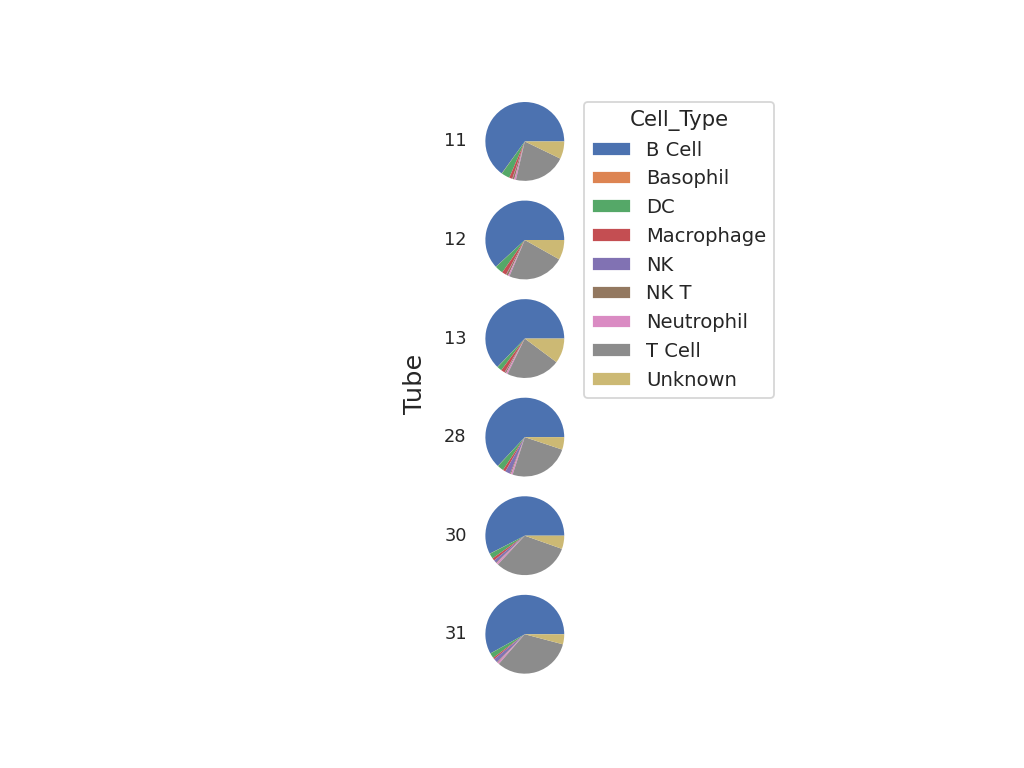

In [23]:
flow.MatrixView(statistic = "Cell_Type", 
                style = "pie", 
                variable = "Cell_Type",
                feature = "FSC_A",
                xfacet = "Tube").plot(ex_hierarchy_count, 
                                      legendlabel = "Cell Type",
                                      linestyle = 'none')

At the end of the day, I don't think that any of these tubes was substantially different from the rest of them.